In [1]:
import nmresearch as nmr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import time
import pickle

In [2]:
# decent color schemes for plots and such

colors = [
    "#1984c5",
    "#22a7f0",
    "#63bff0",
    "#a7d5ed",
    "#e2e2e2",
    "#e1a692",
    "#de6e56",
    "#e14b31",
    "#c23728",
]

colors_single = [
    "#fff5eb",
    "#fee6ce",
    "#fdd0a2",
    "#fdae6b",
    "#fd8d3c",
    "#f16913",
    "#d94801",
    "#a63603",
    "#7f2704",
]
colors_single.reverse()
zcorr_str = r"$\langle$ $\hat{S}_z (nT)$ $\hat{S}_z$ $\rangle$"
xcorr_str = r"$\langle$ $\hat{S}_x (nT)$ $\hat{S}_x$ $\rangle$"
mucorr_str = r"$\langle$ $\hat{S}_\mu (nT)$ $\hat{S}_\mu$ $\rangle$"
zcorr_loc_str = r"$\langle$ $\hat{S}_z^{(0)} (nT)$ $\hat{S}_z^{(0)}$ $\rangle$"

In [3]:
plt.rcParams.update({"font.size": 14})
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"

In [4]:
def get_perc_data(filename):
    filename = "data/" + filename
    try:
        return pickle.load(open(filename, "rb"))
    except FileNotFoundError:
        return None


def expected_nodes(r0):
    return 4 * r0**3 + 6 * r0**2 + 3 * r0 + 1

In [5]:
def dual_plot(cluster, strength, r_list, sig_vals, filename=None):
    fig, ax1 = plt.subplots()
    # ax1.set_yscale("log")
    max_density_sigma = 0
    max_density = 0
    color = "tab:blue"
    ax1.set_xlabel(r"Disorder Strength,  $\sigma / J$")
    ax1.set_ylabel("Average Cluster Size", color=color)
    for idx, r in enumerate(r_list):
        ax1.scatter(
            sig_vals,
            cluster[r],
            label=f"N={expected_nodes(r)}",
            color=color,
            alpha=(idx + 1) / len(r_list),
        )
        ax1.tick_params(axis="y", labelcolor=color)
        if max_density < np.max(cluster[r]):
            max_density_sigma = sig_vals[np.argmax(cluster[r])]
            max_density = np.max(cluster[r])

    ax1.axvline(x=max_density_sigma, color="black", linestyle="--")
    plt.legend(loc="center left", bbox_to_anchor=(1.15, 0.75))

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = "tab:red"
    ax2.set_ylabel(
        "Percolation Strength", color=color
    )  # we already handled the x-label with ax1
    for idx, r in enumerate(r_list):
        ax2.scatter(
            sig_vals,
            strength[r],
            label=f"N={expected_nodes(r)}",
            color=color,
            alpha=(idx + 1) / len(r_list),
        )
        ax2.tick_params(axis="y", labelcolor=color)

    plt.legend(loc="center left", bbox_to_anchor=(1.15, 0.25))
    if filename is not None:
        plt.savefig(filename + ".pdf", format="pdf", dpi=900, bbox_inches="tight")
        plt.savefig(filename + ".png", format="png", dpi=900, bbox_inches="tight")
    plt.show()

In [6]:
r_list = [8, 10, 12, 14, 16]
sig_vals = np.arange(0.1, 10, 0.1)
reps = 100
density = {}
strength = {}

nn_cluster = get_perc_data("nn_cluster.dat")
nn_strength = get_perc_data("nn_strength.dat")
if nn_cluster is None or nn_strength is None:
    nn_cluster = {}
    nn_strength = {}
    fcc = nmr.FccGraph()
    q_calc = nmr.QuantumGraph(fcc)
    for r in r_list:
        start = time.time()
        nn_cluster[r] = [
            q_calc.avg_cluster_size(sigma=sigma, dim=r, layers=1, repititions=reps)
            for sigma in sig_vals
        ]
        nn_strength[r] = [
            q_calc.percolation_strength(sigma=sigma, dim=r, layers=1, repititions=reps)
            for sigma in sig_vals
        ]
        end = time.time()
        print(
            f"Avg Computation time per fcc graph for r={r} is {(end-start)/(reps*len(sig_vals))} s"
        )

    with open("data/nn_cluster.dat", "wb") as f:
        pickle.dump(nn_cluster, f)

    with open("data/nn_strength.dat", "wb") as f:
        pickle.dump(nn_strength, f)

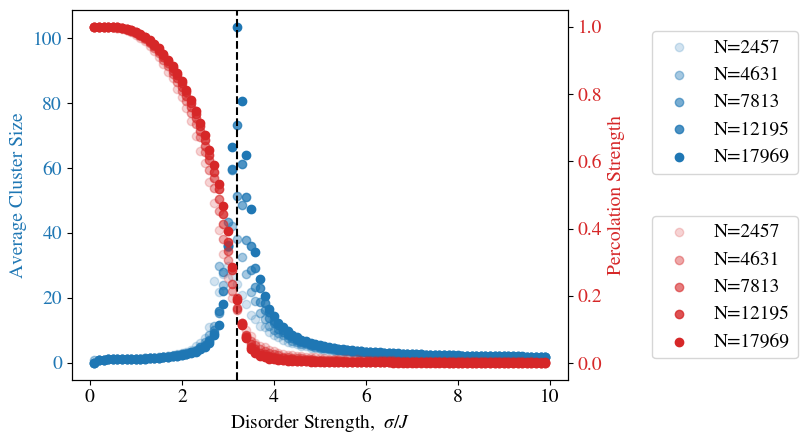

In [7]:
dual_plot(nn_cluster, nn_strength, r_list, sig_vals, "numerical_perc_nn")

In [8]:
def get_perc_data_layers(layers, r_list, sig_vals):
    cluster = get_perc_data(f"n{layers+1}_cluster.dat")
    strength = get_perc_data(f"n{layers+1}_strength.dat")
    if cluster is None or strength is None:
        reps = 200
        cluster = {}
        strength = {}
        fcc = nmr.FccGraph()
        q_calc = nmr.QuantumGraph(fcc)
        for r in r_list:
            start = time.time()
            cluster[r] = [
                q_calc.avg_cluster_size(
                    sigma=sigma, dim=r, layers=layers, repititions=reps
                )
                for sigma in sig_vals
            ]
            strength[r] = [
                q_calc.percolation_strength(
                    sigma=sigma, dim=r, layers=layers, repititions=reps
                )
                for sigma in sig_vals
            ]
            end = time.time()
            print(
                f"Avg Computation time per fcc graph for r={r} is {(end-start)/(reps*len(sig_vals))} s"
            )

        with open(f"data/n{layers+1}_cluster.dat", "wb") as f:
            pickle.dump(cluster, f)

        with open(f"data/n{layers+1}_strength.dat", "wb") as f:
            pickle.dump(strength, f)
    return cluster, strength

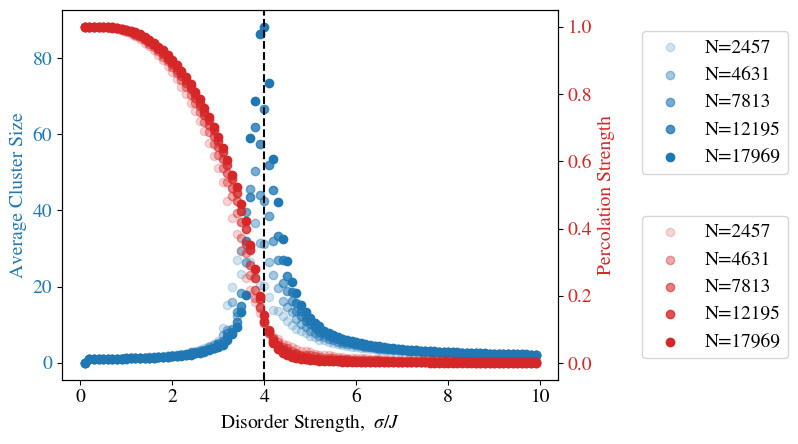

In [9]:
r_list = [8, 10, 12, 14, 16]
sig_vals = np.arange(0.1, 10, 0.1)

n3_cluster, n3_strength = get_perc_data_layers(2, r_list, sig_vals)

dual_plot(n3_cluster, n3_strength, r_list, sig_vals)

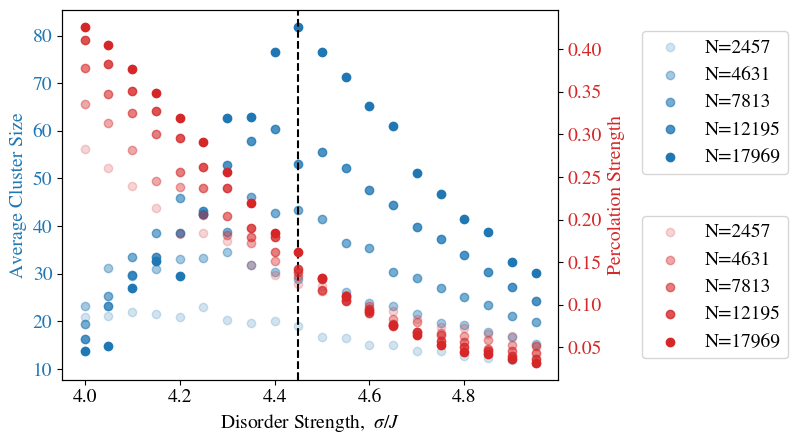

In [10]:
r_list = [8, 10, 12, 14, 16]
sig_vals = np.arange(4, 5, 0.05)
n4_cluster, n4_strength = get_perc_data_layers(3, r_list, sig_vals)


dual_plot(n4_cluster, n4_strength, r_list, sig_vals)

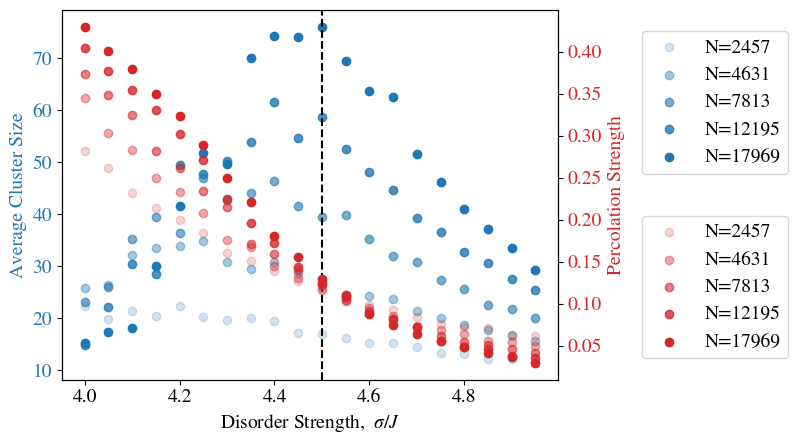

In [11]:
r_list = [8, 10, 12, 14, 16]
sig_vals = np.arange(4, 5, 0.05)
n5_cluster, n5_strength = get_perc_data_layers(4, r_list, sig_vals)


dual_plot(n5_cluster, n5_strength, r_list, sig_vals)

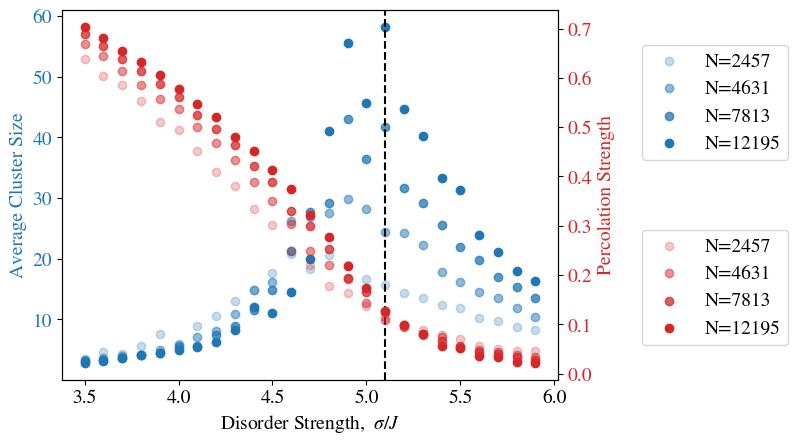

In [12]:
r_list = [8, 10, 12, 14]
sig_vals = np.arange(3.5, 6, 0.1)
n6_cluster, n6_strength = get_perc_data_layers(5, r_list, sig_vals)


dual_plot(n6_cluster, n6_strength, r_list, sig_vals)

In [13]:
r_list = [8, 10, 12, 14, 16]
sig_vals = np.arange(0.1, 10, 0.1)
n7_cluster, n7_strength = get_perc_data_layers(6, r_list, sig_vals)

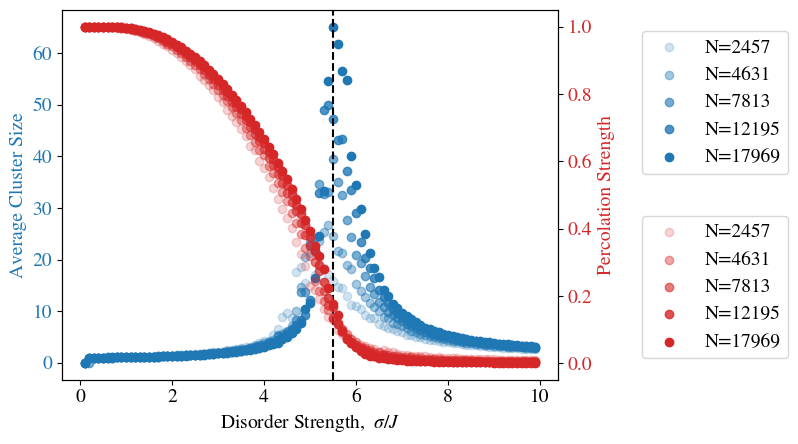

In [14]:
dual_plot(n7_cluster, n7_strength, r_list, sig_vals, "numerical_perc_lr")

In [15]:
a = 1

nn_adjacency = [
    np.array([alpha * a, beta * a, 0]) for alpha in (-1, 1) for beta in (-1, 1)
]

nn_adjacency += [
    np.array([alpha * a, 0, beta * a]) for alpha in (-1, 1) for beta in (-1, 1)
]

nn_adjacency += [
    np.array([0, alpha * a, beta * a]) for alpha in (-1, 1) for beta in (-1, 1)
]


nnn_adjacency = [
    a * alpha * (np.array([1, 1, 1]) + ei) for alpha in (-1, 1) for ei in np.identity(3)
]


nnnn_adjacency = [
    a * alpha * (np.array([1, 1, 1]) - 3 * ei)
    for alpha in (-1, 1)
    for ei in np.identity(3)
]


n5_adjacency = [a * alpha * np.array([1, 1, 1]) for alpha in (-1, 1)]


n6_adjacency = [
    2 * a * np.array([alpha, beta, 0]) for alpha in (-1, 1) for beta in (-1, 1)
]
n6_adjacency += [
    2 * a * np.array([alpha, 0, beta]) for alpha in (-1, 1) for beta in (-1, 1)
]
n6_adjacency += [
    2 * a * np.array([0, alpha, beta]) for alpha in (-1, 1) for beta in (-1, 1)
]

n7_adjacency = [
    2 * a * alpha * (np.array([1, 1, 1]) - 2 * ei)
    for alpha in (-1, 1)
    for ei in np.identity(3)
]
n7_adjacency += [
    a * np.array([alpha, -alpha, 2 * beta]) for alpha in (-1, 1) for beta in (-1, 1)
]
n7_adjacency += [
    a * np.array([alpha, 2 * beta, -alpha]) for alpha in (-1, 1) for beta in (-1, 1)
]
n7_adjacency += [
    a * np.array([2 * beta, alpha, -alpha]) for alpha in (-1, 1) for beta in (-1, 1)
]


neighbors = [
    len(nn_adjacency),
    len(nnn_adjacency),
    len(nnnn_adjacency),
    len(n5_adjacency),
    len(n6_adjacency),
    len(n7_adjacency),
]

running_total_neighbors = np.cumsum(neighbors)

In [16]:
pt_idx = []
clusters = [nn_cluster, n3_cluster, n4_cluster, n5_cluster, n6_cluster, n7_cluster]

for cluster in clusters:
    max_val = 0
    max_idx = 0
    for cluster_size in cluster.values():
        max_local = np.max(cluster_size)
        if max_local > max_val:
            max_val = max_local
            max_idx = list(cluster_size).index(max_local)
    pt_idx.append(max_idx)

sigma_wide = np.arange(0.1, 10, 0.1)
sigma_narrow = np.arange(3.5, 6, 0.1)
sigma_focus = np.arange(4, 5, 0.05)
phase_transitions = [
    sigma_wide[pt_idx[0]],
    sigma_wide[pt_idx[1]],
    sigma_focus[pt_idx[2]],
    sigma_focus[pt_idx[3]],
    sigma_narrow[pt_idx[4]],
    sigma_wide[pt_idx[5]],
]
phase_transitions

[3.2, 4.0, 4.449999999999998, 4.499999999999998, 5.100000000000001, 5.5]

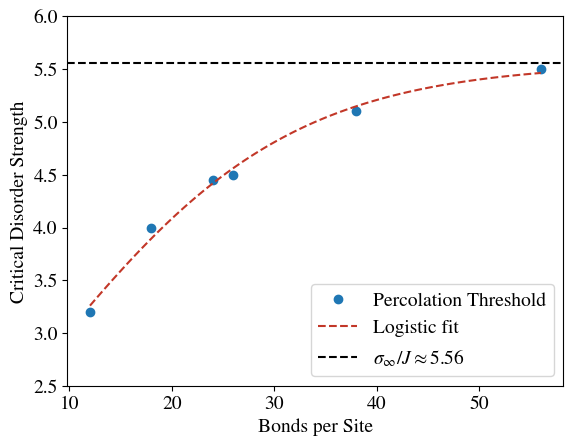

In [17]:
from scipy.optimize import curve_fit

x = running_total_neighbors
y = phase_transitions


def logistic_growth(x, L, x0, k):
    return L / (1 + np.exp(-k * (x - x0)))


popt, pcov = curve_fit(logistic_growth, x, y, p0=[27, -27, 0.05])

x_fit = np.linspace(np.min(x), np.max(x), 100)
y_fit = logistic_growth(x_fit, *popt)

plt.plot(x, y, "o", label="Percolation Threshold")
plt.plot(x_fit, y_fit, "--", label="Logistic fit", color=colors[-1])
sig_inf = round(popt[0], 2)
plt.axhline(
    y=sig_inf,
    color="black",
    linestyle="--",
    label=r"$\sigma_{\infty}/J\approx$" + f"{sig_inf}",
)
plt.ylim([2.5, 6])
plt.xlabel(r"Bonds per Site")
plt.ylabel("Critical Disorder Strength")
plt.legend()
plt.savefig("logistic_fit.pdf", format="pdf", dpi=900, bbox_inches="tight")
plt.savefig("logistic_fit.png", format="png", dpi=900, bbox_inches="tight")
plt.show()

In [18]:
np.sqrt(pcov[0, 0])

0.11298160294925366

In [19]:
x

array([12, 18, 24, 26, 38, 56])

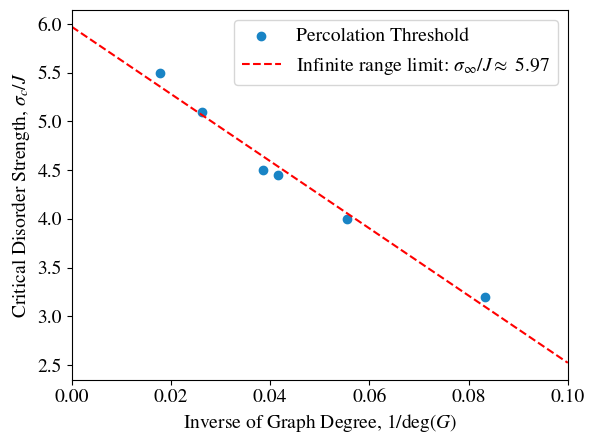

In [21]:
x = 1 / running_total_neighbors
y = phase_transitions
plt.scatter(x, y, label="Percolation Threshold", color=colors[0])
plt.xlim([0, 0.1])

# Perform a linear fit
coefficients = np.polyfit(x, y, 1)
linear_fit = np.poly1d(coefficients)

# Generate y values for the linear fit
x_smooth = np.linspace(0, 0.1, 100)
y_linear_fit = linear_fit(x_smooth)

# Plot the linear fit
plt.plot(
    x_smooth,
    y_linear_fit,
    label=fr"Infinite range limit: $\sigma_\infty/J \approx$ {coefficients[1]:.2f}",
    color="red",
    linestyle="--",
)
plt.xlabel(r"Inverse of Graph Degree, $1 / \text{deg}(G)$")
plt.ylabel(r"Critical Disorder Strength, $\sigma_c / J$")
plt.legend()
plt.savefig("inf_limit.pdf", format="pdf", dpi=900, bbox_inches="tight")
plt.savefig("inf_limit.png", format="png", dpi=900, bbox_inches="tight")
plt.show()